In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import numpy as np

def get_stock_data(symbol,duration):
    def mkdays(val):
        return val.days
    def mkdaystr(val):
        return val.strftime('%Y.%m.%d')
    df = yf.Ticker(symbol).history(duration)
    df['Company'] = symbol
    df['Date'] = df.index
    df.reset_index(drop=True, inplace=True)
    vals = df.Date - df.Date[0] 
    df['Days'] = list( map( mkdays, vals ) )
    df['Daystring'] = list( map( mkdaystr, df.Date ) )
    # df = df[['Date','Company','Close','Volume']]
    return df

def thinticks(df, showeach):
    val = df.Days
    lab = df.Date
    vals = []
    labs = []
    k = 0
    while k < len(val):
        vals.append( val[k] )
        labs.append( lab[k].strftime('%Y.%m.%d') )
        k = k + showeach
    return vals, labs
    
def standard_plot(df, showeach, title_string, window):
    def findwindowave(values, window):
        mx = len(values)
        windowave = []
        for k in range(0,mx):
            left = right = k
            if k > window:
                left = k - window
            if (k+window) < mx:
                right = k + window
            windowave.append( np.average( values[left:right] ) )
        return windowave
    
    plt.figure(figsize=(9,3))
        
    x, y = df.Days, df.Close
    plt.scatter(x, y,  s=1, c='black')
    plt.scatter(x, findwindowave(y, window),  s=10, c='black')
    #plt.scatter(x, df.Low,  s=1, c='blue')
    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs, rotation=90)
    plt.ylabel('Close $')
    plt.xlabel('Date')
    plt.title(title_string)
    
    plt.show()
    
def findwindowave(values, window):
    mx = len(values)
    windowave = []
    for k in range(0,mx):
        left = right = k
        if k > window:
            left = k - window
        if (k+window) < mx:
            right = k + window
        windowave.append( np.average( values[left:right] ) )
    return windowave


# This creates a plot with two axis.  One in $ and the second as Fraction relative
# to the observed minimum.  
def doubleplot(df, showeach, title_string, window):
    x = df.Days
    y = df.Close
    yavg = findwindowave(y, window)
    mn = min( list(df.Close) )
    ynorm = df.Close / mn
    ynormf = findwindowave(ynorm, window)
    
    
    fig, ax1 = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Share Price [$]', color='black')
    ax1.plot(x, y, linestyle='None', marker='.', color='blue', markersize=5)
    ax1.plot(x, yavg, linestyle='None', marker='.', color='green', markersize=10)
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    # this is an invisible series intentionally right now.  
    # the 'Fraction' axis is slightly offset from the $ axis.  
    # This will be fixed but currently the Fraction axis serves to show 
    # the percentage gain/losses compared to the minima seen on the current time 
    # window

    ax2.set_ylabel('Fraction', color='black')  # we already handled the x-label with ax1
    ax2.plot(x, ynormf, linestyle='None', marker='.', color='black', markersize=0)
    ax2.tick_params(axis='y', labelcolor='black')
    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs)
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    plt.title(title_string)

    plt.show()
    standard_plot(df, showeach, title_string, window)


# This creates a plot with two axis.  One is value invested
def doubleplot_(df, showeach, title_string, window):
    x = df.Days
    
    fig, ax1 = plt.subplots()
    fig.set_figheight(3)
    fig.set_figwidth(9)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value Owned[$]', color='black')
    ax1.plot(x, df.value, linestyle='None', marker='.', color='blue', markersize=5)
    ax1.plot(x, df.spent, linestyle='None', marker='.', color='green', markersize=10)
    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped

    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs)
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    plt.title(title_string)

    plt.show()
    standard_plot(df, showeach, '', window)

    
def create_invested(invested,df):
    df.loc[( (df.Daystring>=invested[0]) ),'shares'] = \
        df.loc[( (df.Daystring>=invested[0]) ),'shares'] + invested[2]
    df.loc[( (df.Daystring>=invested[0]) ),'spent'] = \
        df.loc[( (df.Daystring>=invested[0]) ),'spent'] + invested[1]    
    return df

def add_instestments(df,investments,symbol):
    df['shares'] = 0.00 
    df['spent'] = 0.00 
    df['gain'] = 0.00 
    for invest in investments[symbol]:
        df = create_invested(invest,df)
        df['value'] = df['Close'] * df['shares']
        df.loc[( (df['shares']>0.00) ),'gain'] = \
           df.loc[( (df['shares']>0.00) ),'value']/df.loc[( (df['shares']>0.00) ),'spent']
    return df   


def portfolio_value(investments, symbol, latest_date):
    invested = investments[symbol]
    df = yf.Ticker(symbol).history('1d')
    shares = 0
    outlay = 0
    close = 0
    first_investment = '9999.99.99'
    last_investment = '1111.11.11'
    investment_made = len(invested)
    for investment in invested:
        if (investment[0]<latest_date):
            shares = shares + investment[2]
            outlay = outlay + investment[1]
        if (investment[0]<first_investment): first_investment = investment[0]
        flag = ( investment[0]>last_investment, investment[1]>0)
        if flag == (True,True): last_investment = investment[0]
    if (shares,outlay) != (0,0):
        if np.isnan(df.Close[0]):
            value = 0
            price = 0
            close = 0
            message = 'No close value found for {0}'.format(symbol)
            print(message)
            message = 'raw data was:'
            print(message)
            print(df.head(1))
        else:
            close = df.Close[0]
            value = shares * close
            price = df.Close[0]
        ratio = value/outlay   
    else:
        close = df.Close[0]
        value = 0
        price = df.Close[0]
        ratio = 1.00
    result = {'symbol':symbol,'price':price,'shares': \
              shares,'value': value,'outlay': outlay, 'close':close, 'ratio':ratio, 
              'first_investment': first_investment,
              'last_investment': last_investment,
              'investments_made': investment_made
             }
    return result


def rgb_gain(gain, mingain, green_point, maxgain):
    clrs = []
    for gp in gain:
        if gp < green_point:
            # (1,0,0) -> (5/11,5/11,1/11)
            # slider = 0 when gp==greenpoint, 1 when gp = mingain
            slider = (green_point - gp) / (green_point - mingain)
            rc = 1.00
            gc = (1-slider)
            bc = 0
            clrs.append((rc,gc,bc))
        if gp >= green_point:
            # gp == green_point, slider = 0 
            slider = (gp - green_point) / (maxgain - green_point)
            bc = slider
            gc = 1.00 - bc
            clrs.append((0,gc,bc))
    return clrs
        

In [2]:
description = {
    'OKTA':{'area':'US','sector':'Tech, Security'}
    ,'AMZN':{'area':'US','sector':'Virtual Marketplace, Cloud Services'}
    ,'APPN':{'area':'US','sector':'Tech, Business Processes'}
    ,'WORK':{'area':'US','sector':'Tech, Business Communications'}
    ,'ALB':{'area':'US','sector':'Li Mining, Specialty Chemicals'}
    ,'ADBE':{'area':'US','sector':'Tech, Creative'}
    ,'ESTC':{'area':'US','sector':'Tech, DB'}
    ,'GOOGL':{'area':'US','sector':'Tech, ecclectic'}
    ,'SQM':{'area':'Latin America','sector':'Li Mining, Specialty Chemicals'}
    ,'LTHM':{'area':'US','sector':'Li Battery'}
    ,'TMUS':{'area':'US','sector':'Cellular'}
    ,'MMM':{'area':'US','sector':'Industrial'}
    ,'LMND':{'area':'US','sector':'Insurance-Tech'}
    ,'NHI':{'area':'US','sector':'REIT'}
    ,'ULTA':{'area':'US','sector':'Cosmetics'}
    ,'MELI':{'area':'Latin America','sector':'Virtual Marketplace'}
    ,'JD':{'area':'China','sector':'Virtual Marketplace'}
    ,'CVS':{'area':'US','sector':'Retail Pharmacy'}
    ,'RDFN':{'area':'US','sector':'Real Estate Tech'}
    ,'NIO':{'area':'China','sector':'Electric Vehicle, High End'}
    ,'BABA':{'area':'China','sector':'Virtual Marketplace, Cloud Services'}
    ,'JMIA':{'area':'Africa','sector':'Virtual Marketplace'}
    ,'ETHE':{'area':'US','sector':'Cryptocurrency'}
    ,'GBTC':{'area':'US','sector':'Cryptocurrency'}
    ,'SE':{'area':'Southeast Asia','sector':'Virtual Marketplace'}
}

investments = {
    'OKTA':[('2020.05.20',250,1.33192)],
    'ADBE':[
           ('2020.06.05',250,0.6363), 
           ('2020.06.22',80,0.18239)
           ],
    'AMZN':[
           ('2020.03.10',250,0.1373),
           ('2020.04.02',500,0.26057),
           ('2020.04.06',250,0.12515),
           ('2020.04.26',500,0.21043),
           ('2020.05.06',250,0.10632),
           ('2020.05.27',500,0.20823),
           ('2020.06.18',500,0.18839)
           ],
    'APPN':[('2020.02.22',300,6.413)],
    'WORK':[
            ('2020.02.22',300,10.74499),
            ('2020.03.10',500,21.16851)
           ],
    'ALB':[
           ('2020.02.22',300,3.34785),
           ('2020.03.02',250,2.9656),
           ('2020.03.10',500,7.1353),
           ('2020.04.04',250,4.39136)
          ],
    'ESTC':[
           ('2020.04.21',250,4.26913), 
           ('2020.09.22',500,4.61766)
           ],
    'RDFN':[
            ('2020.03.05',600,20.82611),
            ('2020.03.10',250,11.51013)
           ],
    'GOOGL':[('2020.02.28',500,0.36067)],
    'SQM':[
           ('2020.03.03',500,17.08818),
           ('2020.03.11',500,20.88555)
          ],
    'LTHM':[('2020.03.11',100,16.33987)],
    'NHI':[('2020.08.05',2000,32.07699)],
    'MMM':[('2020.07.07',200,1.29183)],
    'TMUS':[('2020.07.07',100,0.94518),
            ('2020.07.22',100,0.95302)],
    'LMND':[('2020.07.29',300,4.34468), 
            ('2020.08.13',500,8.4374),
           ('2020.10.01',500,9.71629)],
    'ULTA':[('2020.08.20',1000,4.6729),
            ('2020.10.1',500,2.18694)],
    'MELI':[('2020.08.20',2000,1.66351)],
    'JD':[('2020.10.16',1000,12.26693),
         ('2020.12.18',500,6.13272)],
    'CVS':[('2020.10.16',1000,17.01259)],
    'NIO':[('2020.11.09',300,6.81509)],
    'BABA':[('2020.11.27',650,2.35099),
           ('2020.12.18',500,1.92308)],
    'GBTC':[('2020.12.21',500,16.20746)],
    'ETHE':[('2020.12.21',500,22.99909),('2020.12.23',500,500/19.66)],
    'JMIA':[('2020.12.21',500,11.97319)],
    'SE':[('2020.12.22',500,2.49191)],
}

dividends = {
    'SQM':[('2020.06.23',4.39), ('2020.06.02',6.61)],
    'ALB':[('2020.04.02',5.18),('2020.07.02',6.87),
           ('2020.10.02',5.18),('2020.07.02',6.87)],
    'MMM':[('2020.09.15',1.9)]
}

sold = {
    'TSLA':[('2020.03.06',-500,0.71075),
            ('2020.03.11',-500,0.78836),
            ('2020.03.18',-250,0.6921),
            ('2020.08.18',4135.01,2.19121)],
    'T':[{'2020.10.15',2043.72,74.45249}]
}

In [3]:
symbols = [
 'OKTA',
 'AMZN',
 'APPN',
 'WORK',
 'ALB',
 'ADBE',
 'ESTC',
 'GOOGL',
 'SQM',
 'LTHM',
 'TMUS',
 'MMM',
 'LMND',
 'NHI',
 'ULTA',
 'MELI',
 'JD',
 'CVS',
 'RDFN',
 'NIO',
 'BABA',
 'JMIA',
 'GBTC',
 'ETHE',
 'SE'
]
total = list( map(portfolio_value, [investments]*len(symbols), symbols, ['2021.06.01']*len(symbols)) )

In [4]:
total[0]['first_investment']

'2020.05.20'

OKTA


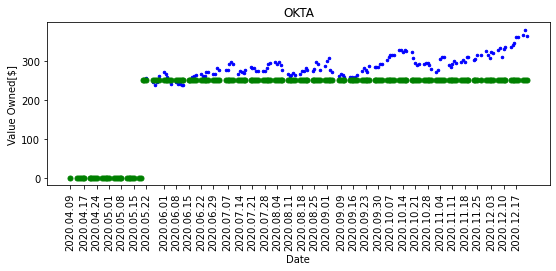

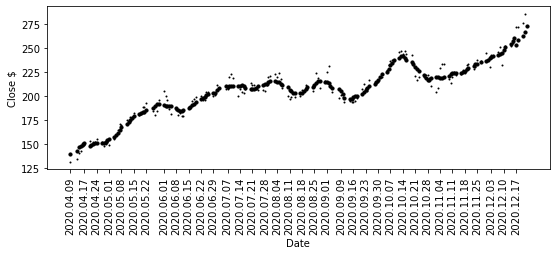

ADBE


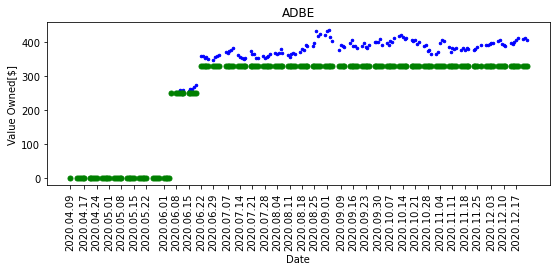

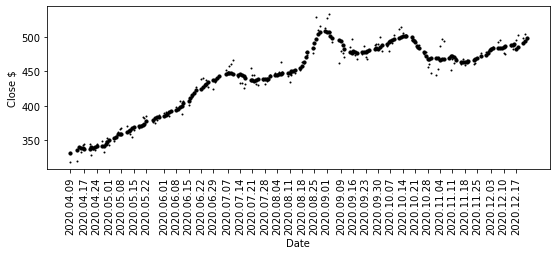

AMZN


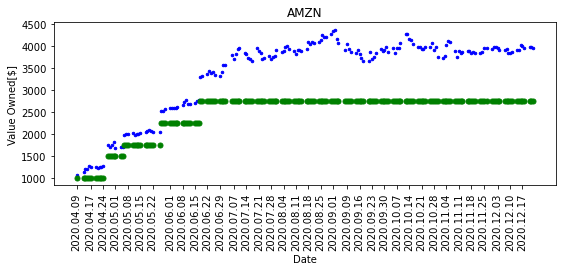

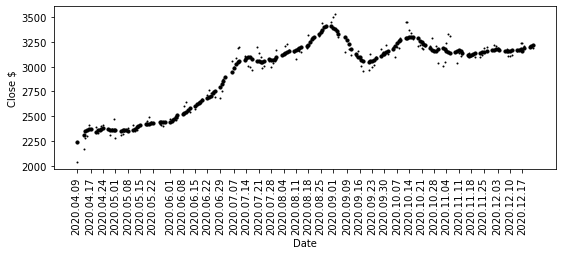

APPN


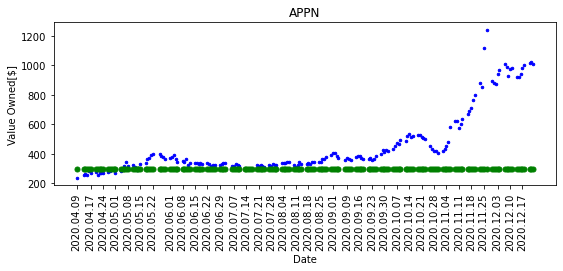

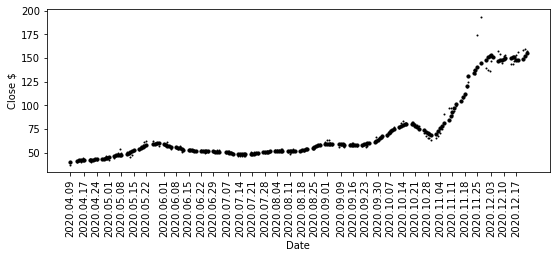

WORK


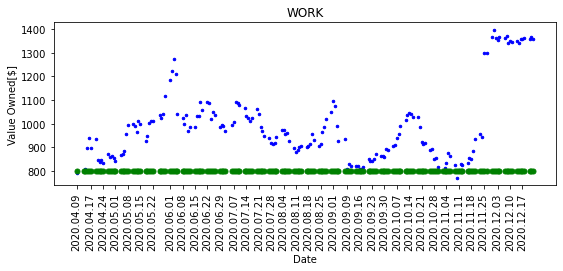

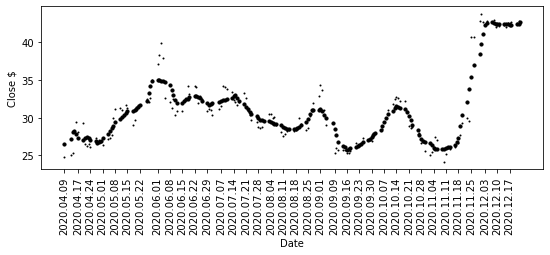

ALB


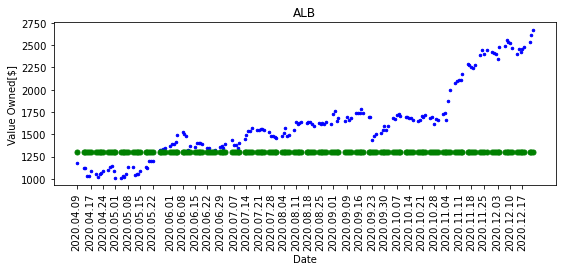

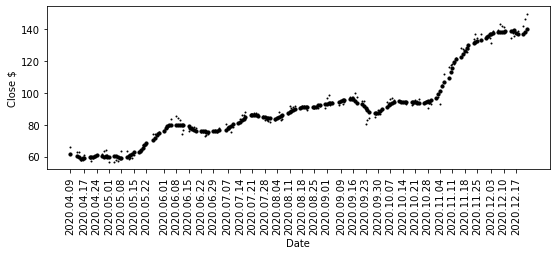

ESTC


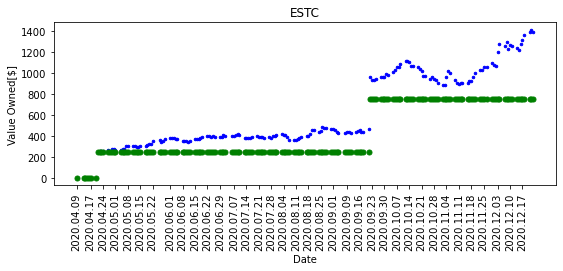

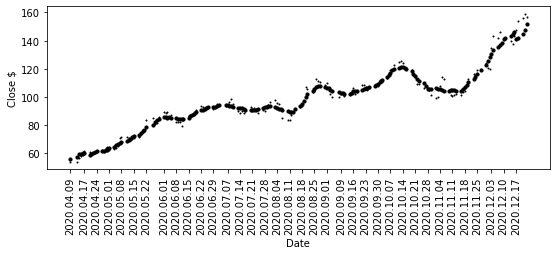

RDFN


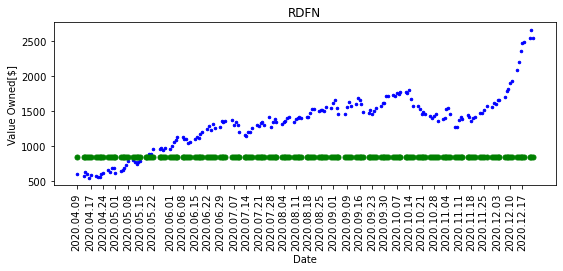

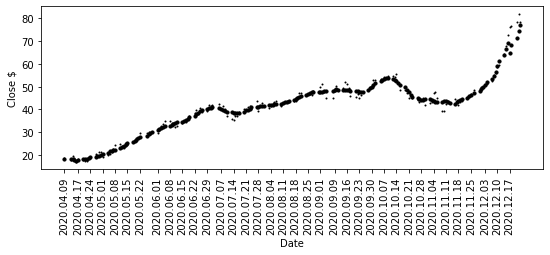

GOOGL


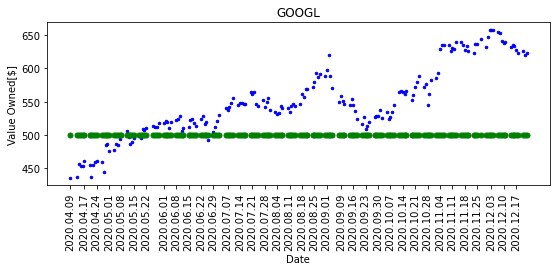

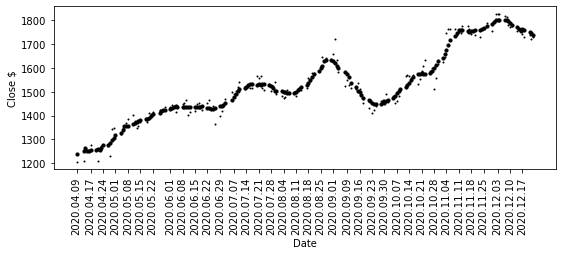

SQM


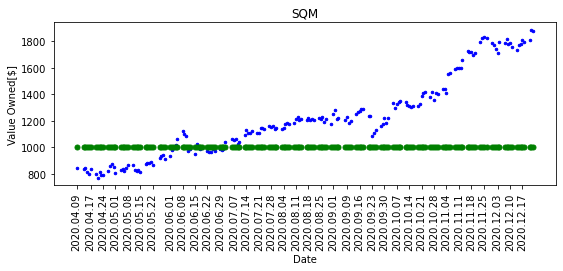

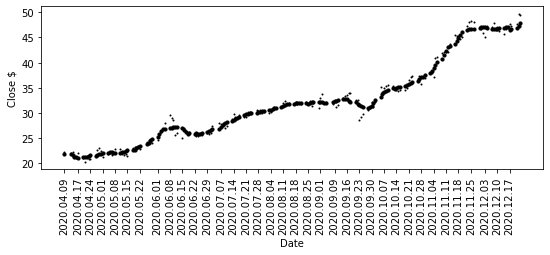

LTHM


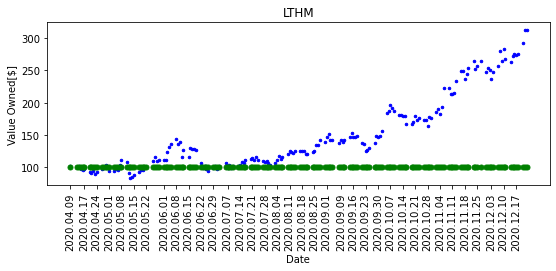

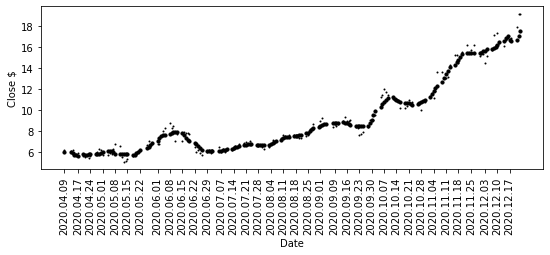

NHI


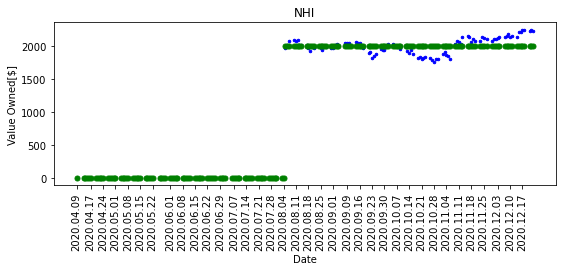

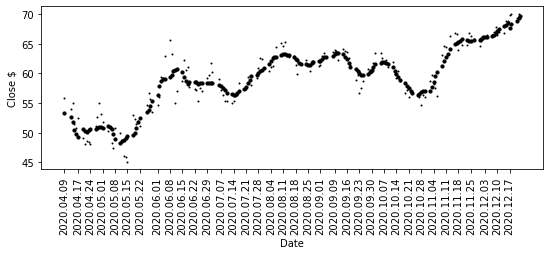

MMM


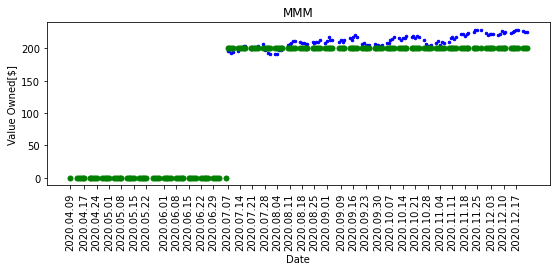

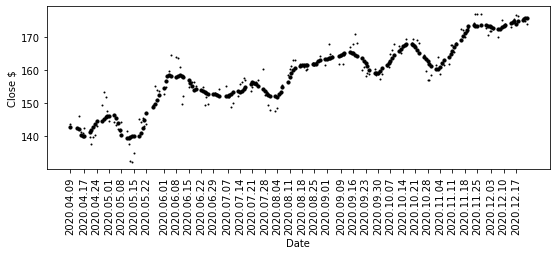

TMUS


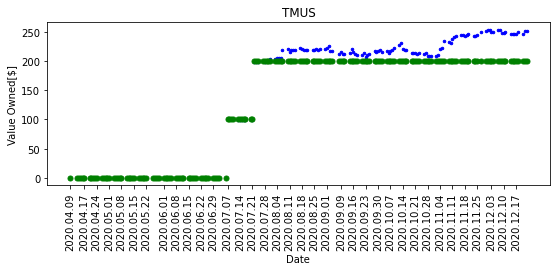

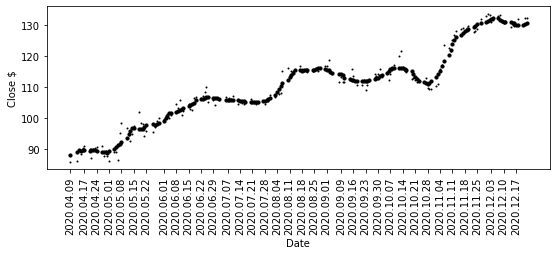

LMND


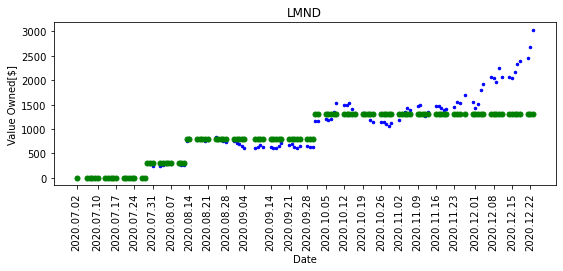

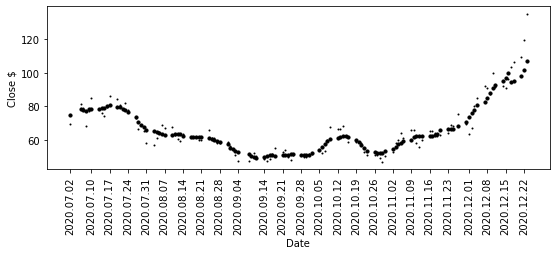

ULTA


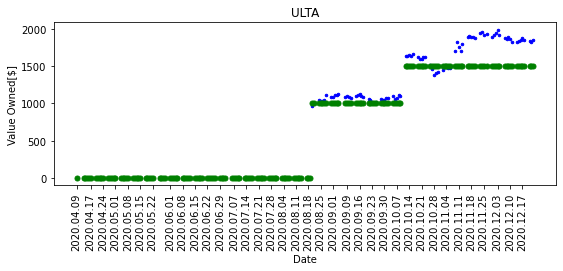

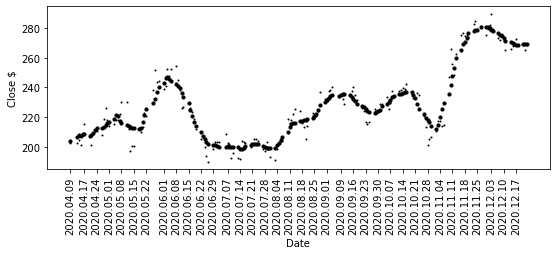

MELI


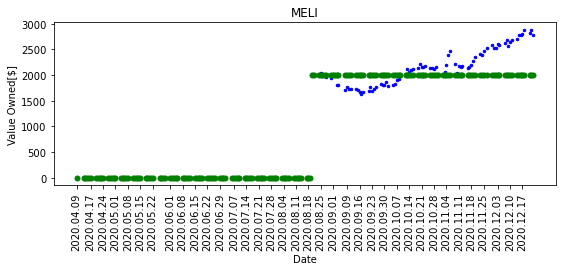

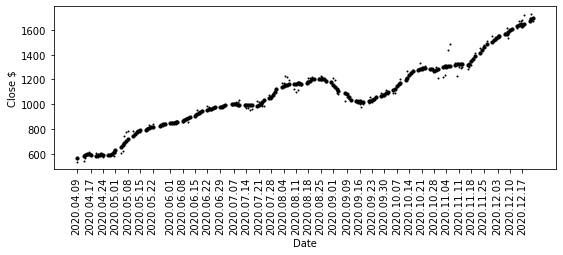

JD


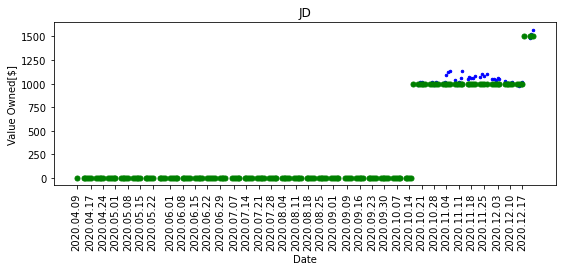

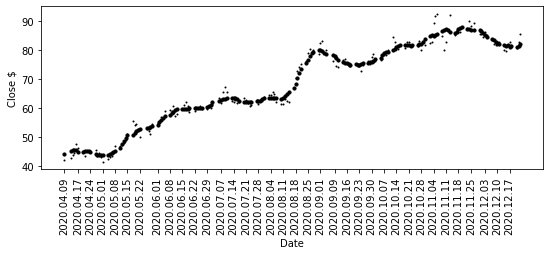

CVS


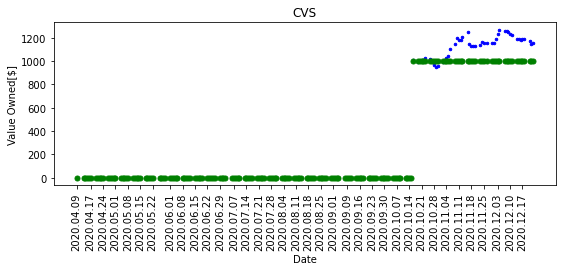

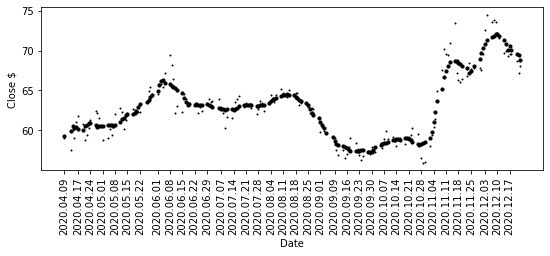

NIO


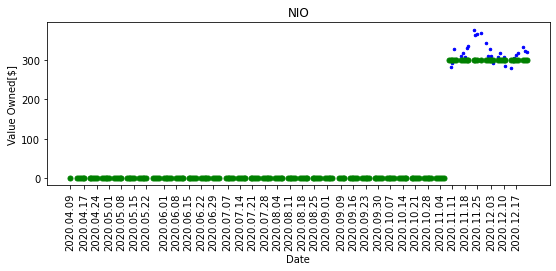

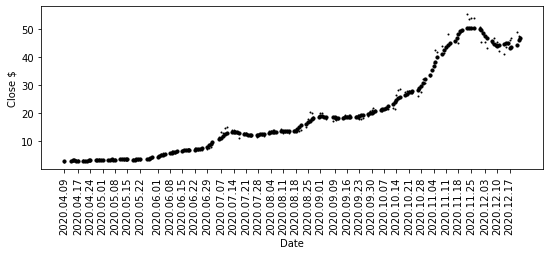

BABA


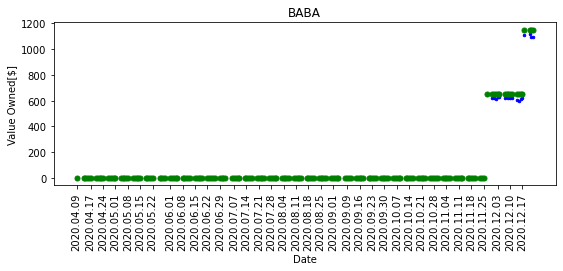

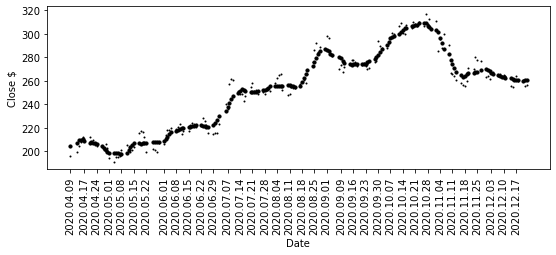

GBTC


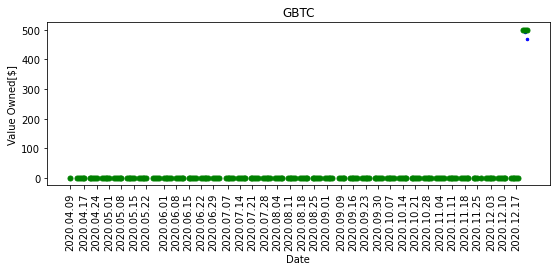

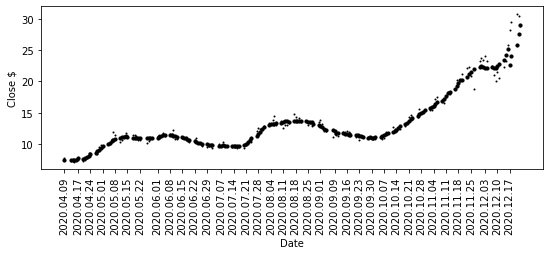

ETHE


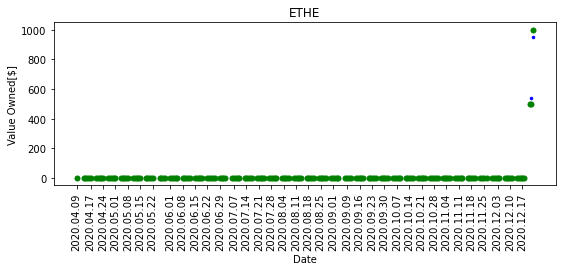

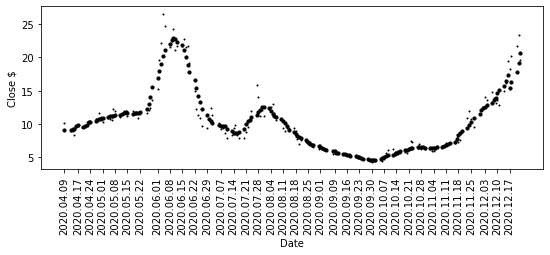

JMIA


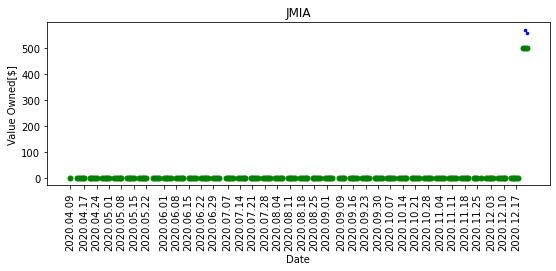

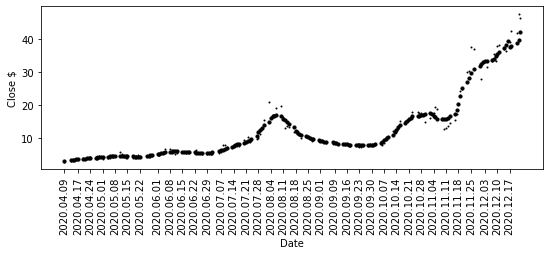

SE


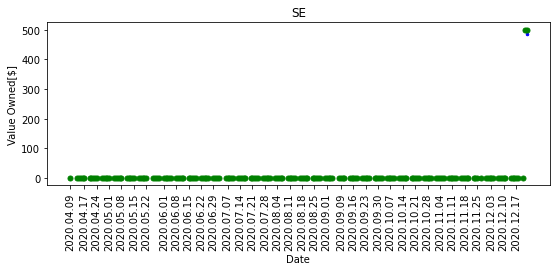

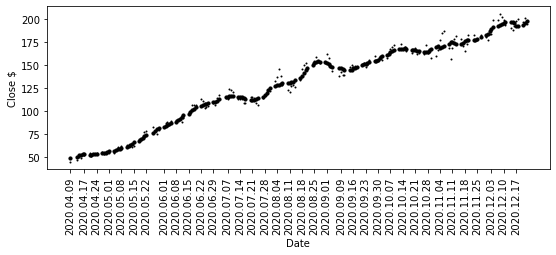

In [5]:
showeach = 5
duration = '180d'
window = 5

for symbol in investments.keys():
    print(symbol)
    df = get_stock_data(symbol,duration)
    df = add_instestments(df,investments,symbol)
    title_string = symbol
    #doubleplot(df, showeach, title_string, window)
    doubleplot_(df, showeach, title_string, window)

In [6]:
outlay = value = 0
labels = []
val_ = []
inv_ = []
per_ = []
gain_ = []
shares = []
close = []
sector = []
area = []
first_invested = []
last_invested = []
investments_made = []
for tik in total:
    outlay = tik['outlay']+ outlay
    value = tik['value']+value
    labels.append(tik['symbol'])
    val_.append(tik['value'])
    inv_.append(tik['outlay'])
    gain_.append(tik['ratio'])
    shares.append(tik['shares'])
    close.append(tik['close'])
    area.append(description[tik['symbol']]['area'])
    sector.append(description[tik['symbol']]['sector'])
    first_invested.append(tik['first_investment'])
    last_invested.append(tik['last_investment'])
    investments_made.append(tik['investments_made'])

# print((outlay,value,value/outlay))
import pandas as pd

df = pd.DataFrame.from_dict({'symbol':labels,
                             'close':close,
                            'invested':inv_,
                            'value':val_,
                             'gain':gain_,
                             'shares':shares,
                             'sector':sector,
                             'area':area,
                             'first_invested':first_invested,
                             'last_invested':last_invested,
                             'investments_made':investments_made
                            }).sort_values(by=['gain'])

df['percentage_invested'] = df.invested/sum(df.invested)
df['percentage_value'] = df.value/sum(df.value)
df['cp'] = df['invested']/df['shares']

fields = ['symbol','gain','invested','value','shares','close','cp','percentage_value']
df[fields].head(30)



,symbol,gain,invested,value,shares,close,cp,percentage_value
22,GBTC,0.936143,500,468.071431,16.20746,28.879999,30.849991,0.013986
23,ETHE,0.951920,1000,951.919985,48.43144,19.655001,20.647745,0.028444
20,BABA,0.952114,1150,1094.931221,4.27407,256.179993,269.064381,0.032717
24,SE,0.972194,500,486.096902,2.49191,195.070007,200.649301,0.014525
16,JD,1.048289,1500,1572.434072,18.39965,85.459999,81.523290,0.046985
19,NIO,1.067925,300,320.377369,6.81509,47.009998,44.019962,0.009573
21,JMIA,1.112070,500,556.034927,11.97319,46.439999,41.759965,0.016614
13,NHI,1.115477,2000,2230.954752,32.07699,69.550003,62.349990,0.066661
11,MMM,1.123828,200,224.765509,1.29183,173.990005,154.819133,0.006716
17,CVS,1.157026,1000,1157.026282,17.01259,68.010002,58.779998,0.034572


In [7]:
print('')
fields = ['symbol','gain','invested','area','sector','first_invested','last_invested','investments_made']
df[fields].sort_values(by=['last_invested']).head(30)

,symbol,gain,invested,area,sector,first_invested,last_invested,investments_made
2,APPN,3.362763,300,US,"Tech, Business Processes",2020.02.22,2020.02.22,1
7,GOOGL,1.246641,500,US,"Tech, ecclectic",2020.02.28,2020.02.28,1
18,RDFN,2.981782,850,US,Real Estate Tech,2020.03.05,2020.03.10,2
3,WORK,1.697798,800,US,"Tech, Business Communications",2020.02.22,2020.03.10,2
9,LTHM,3.135621,100,US,Li Battery,2020.03.11,2020.03.11,1
8,SQM,1.880079,1000,Latin America,"Li Mining, Specialty Chemicals",2020.03.03,2020.03.11,2
4,ALB,2.057239,1300,US,"Li Mining, Specialty Chemicals",2020.02.22,2020.04.04,4
0,OKTA,1.451899,250,US,"Tech, Security",2020.05.20,2020.05.20,1
1,AMZN,1.432086,2750,US,"Virtual Marketplace, Cloud Services",2020.03.10,2020.06.18,7
5,ADBE,1.232773,330,US,"Tech, Creative",2020.06.05,2020.06.22,2


In [8]:
df['dif'] = df['value'] - df['invested']

i = sum(df.invested)
v = sum(df.value)
g = v/i

print('Raw')
print('Total value: \t\t{:8.2f}\nTotal invested: \t{:8.2f}\nTotal gain: \t\t{:8.2f}'.format(
    v,
    i,
    (v-i)
    )
)
print((int(i),int(v),int(g*100)))

tesla_invested = 1250
att_invested = 2416.28
intel_invested = 2000
reinvest_baba = 500
reinvest_jd = 500
reinvest_jmia = 500
reinvest_ethe = 500
reinvest_gbtc = 500
reinvest_se = 500
reinvested = sum([reinvest_baba,reinvest_jd ,reinvest_jmia, reinvest_ethe, reinvest_gbtc, reinvest_se])
cash = 1275.02
i = i + tesla_invested + att_invested + intel_invested - reinvested - cash
g = v/i

print('\nAdjusted for loss and sales')
print('Total value: \t\t{:8.2f}\nTotal invested: \t{:8.2f}\nTotal gain: \t\t{:8.2f}'.format(
    v,
    i,
    (v-i)
    )
)

print((int(i),int(v),int(g*100)))

Raw
Total value: 		33467.04
Total invested: 	22580.00
Total gain: 		10887.04
(22580, 33467, 148)

Adjusted for loss and sales
Total value: 		33467.04
Total invested: 	23971.26
Total gain: 		 9495.78
(23971, 33467, 139)


In [9]:
def mklab(s1,s2,s3,s4,s5):
    return '{0}\ninvested:{1}\nvalue:{2}\ngain:{3:6.4f}\nshares:{4:6.4f}'.format(s1,s2,int(s3),s4,s5)

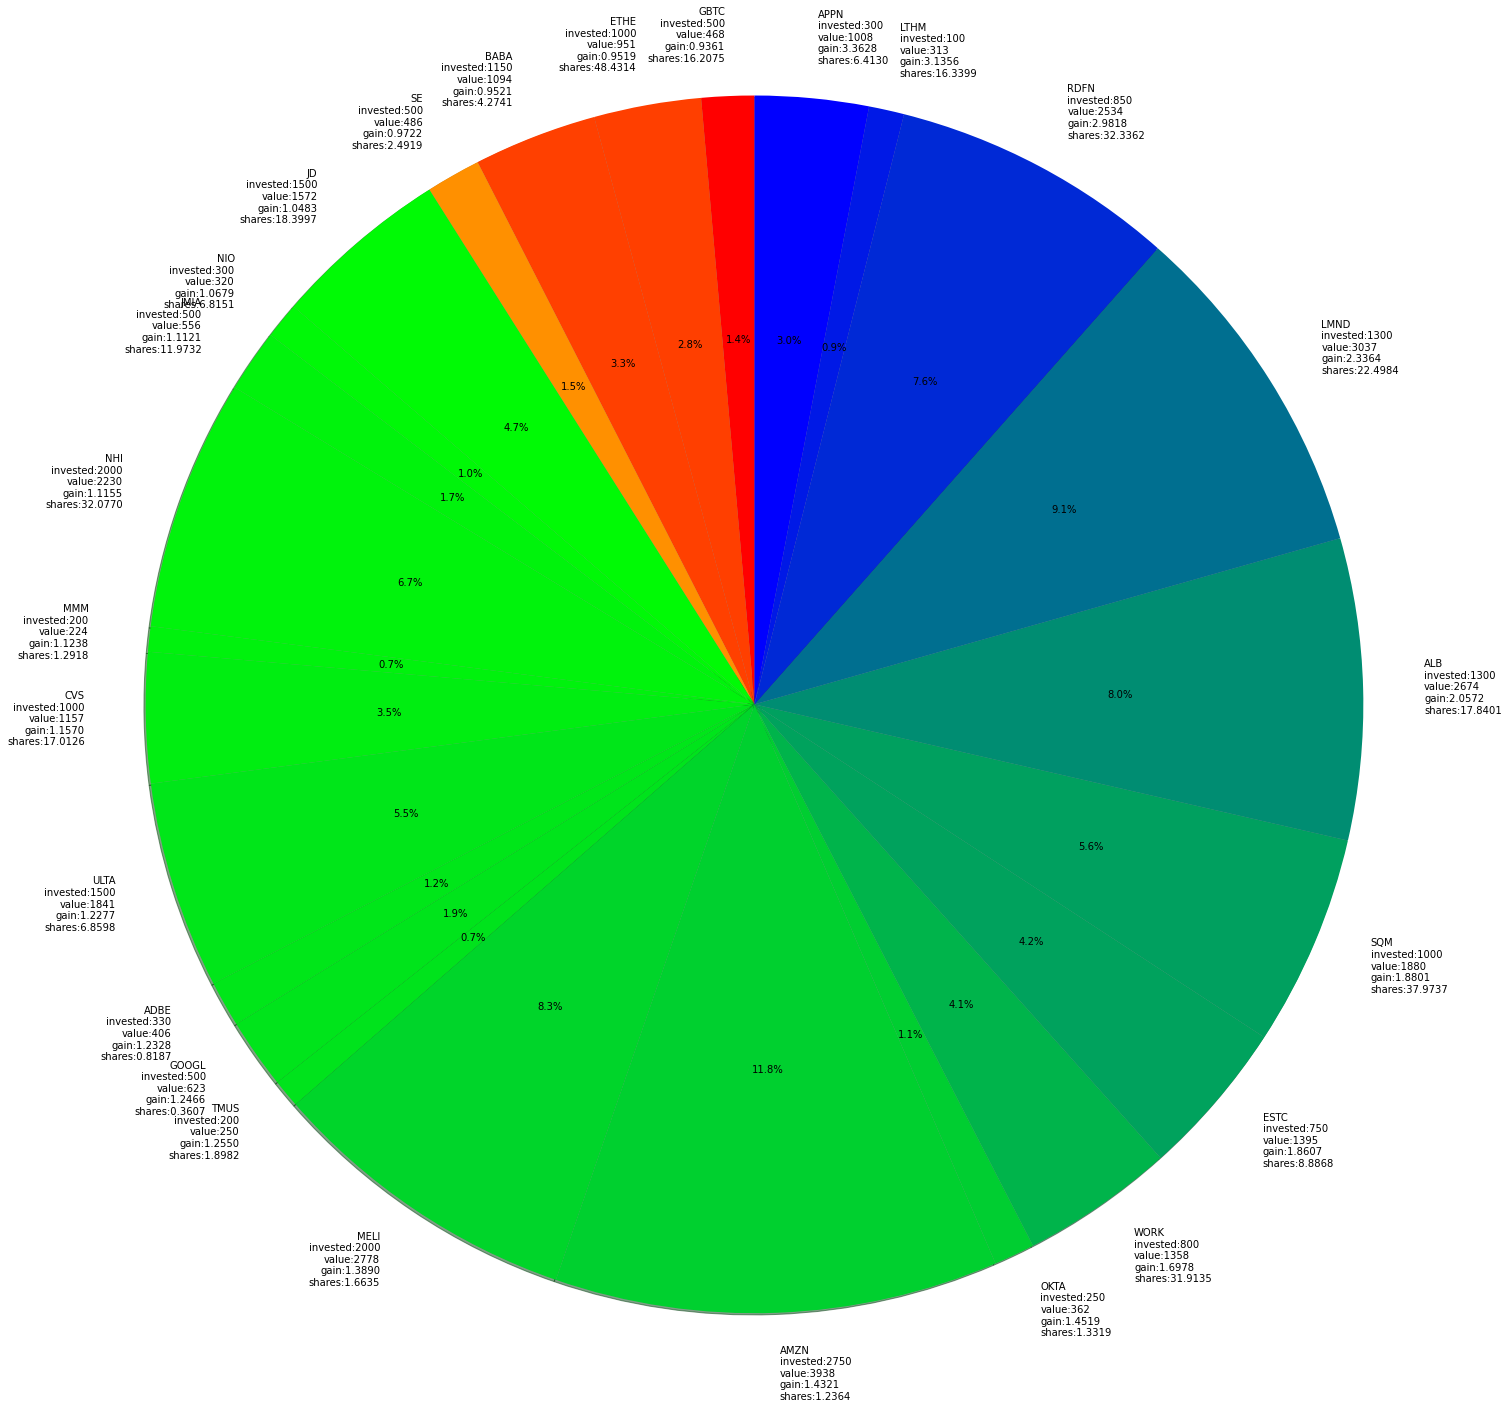

In [10]:
fig1, ax1 = plt.subplots()
df = df.sort_values(by=['gain'])
# rgb_gain(df.gain,0.8,0.95,2)
mn = min( min(df.gain), 0.95)
mx = max( max(df.gain), 3)
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
ax1.pie(df.value, labels=label_, autopct='%1.1f%%', shadow=True, radius=7, startangle=90, \
        colors=rgb_gain(df.gain,mn,1.0,mx) )
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
df = df.sort_values(by=['value'])
# rgb_gain(df.gain,0.8,0.95,2)
# mn = min( min(df.invested), 1)
# mx = max( max(df.invested), 1)
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
ax1.pie(df.value, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90, \
        colors=rgb_gain(df.gain,mn,1.0,mx) )
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
df = df.sort_values(by=['value'])
# rgb_gain(df.gain,0.8,0.95,2)
mn = min( min(df.value), 1)
mx = max( max(df.value), 1)
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
ax1.pie(df.value, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90, \
        colors=rgb_gain(df.value,mn,np.median(df.value),mx) )
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
df = df.sort_values(by=['gain']) 
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
fig1, ax1 = plt.subplots()
ax1.pie(df.invested, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
showeach = 7
duration = '168d'
window = 7

def ploto(symbol,showeach, duration, window):
    title_string = symbol
    df = get_stock_data(symbol, duration)
    standard_plot(df, showeach, title_string, window)

for symbol in ['SE','JMIA','LMND','MELI', 'INTC', 'AMD', 'T', 'TMUS', 'RDFN']:
    ploto(symbol, showeach, duration, window)



In [ ]:
showeach = 7
duration = '112d'
window = 3



In [ ]:
symbol = 'ADBE'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)




In [ ]:
# ATT 0.52 dividend per share.  $30 on Jun-5.
symbol = 'T'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# T Mobile
symbol = 'TMUS'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3M - aristocrat
symbol = 'MMM'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'FSLY'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'CRWD'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
showeach = 7
duration = '112d'
window = 7

# Costco and Kroger
symbol = 'COST'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'KR'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'WMT'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'MELI'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'SQ'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Dominiion energy
symbol = 'D'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
showeach = 7
duration = '56d'
window = 7

# Education online
symbol = 'TWOU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'CHGG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'BEDU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
showeach = 7
duration = '56d'
window = 7

# Zillow 
symbol = 'ZG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# Redfin 
symbol = 'RDFN'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'ROKU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# 3D printer.  Proto Labs
symbol = 'PRLB'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3D printer.  Strata Sys.  
symbol = 'SSYS'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3D printer.  3D Systems
symbol = 'DDD'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Fuel cell.  
symbol = 'PLUG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# Fuel cell.  Vancouver
symbol = 'BLDP'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'ORCL'
title_string = symbol
df = get_stock_data(symbol,duration)
standard_plot(df, showeach, title_string, window)

symbol = 'MU'
title_string = symbol
df = get_stock_data(symbol,duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
df.head(120)

In [ ]:
duration = '5d'
symbol = 'T'
df = yf.Ticker(symbol).history(duration)

In [ ]:
def rgb_steps(steps):
    def rg_steps(steps_rg):
        clrs = []
        for tckr in range(0,steps_rg):
            gclr = 1.00 * (tckr/steps_rg)
            rclr = 1.00 - gclr
            clrs.append((rclr,gclr,0))
        return clrs
    def gb_steps(steps_gb):
        clrs = []
        for tckr in range(0,steps_gb):
            bclr = 1.00 * (tckr/steps_gb)
            gclr = 1.00 - bclr
            clrs.append((0,gclr,bclr))
        return clrs
    
    mdpnt = int(steps/2)
    fnl = steps - mdpnt
    clrs = rg_steps(mdpnt) + gb_steps(fnl)
    return clrs


rgb_steps(22)
